# ResNet



In [1]:
# python -m pip install numpy pandas matplotlib scikit-learn
# conda install pytorch torchvision torchaudio -c pytorch -c nvidia
# pip install torchvision --extra-index-url https://download.pytorch.org/whl/cu126

In [2]:
!python -V

Python 3.12.4


In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import utils

In [4]:
BATCH_SIZE = 256
LR = 0.05
NUM_EPOCHS = 10

## 1. 查看 GPU 配置

<!-- 安装 [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit) -->

In [5]:
!nvidia-smi

Mon Sep  9 02:52:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P8              2W /  140W |     495MiB /   8188MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
utils.try_gpu()

device(type='cuda', index=0)

In [7]:
print(f'CUDA Version: {torch.version.cuda}')
print("Number of GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} Name:", torch.cuda.get_device_name(i))

CUDA Version: 12.4
Number of GPUs: 1
GPU 0 Name: NVIDIA GeForce RTX 4070 Laptop GPU


## 2. 数据预处理

加载和预处理 Fashion-MNIST 数据集

In [8]:
transform = transforms.Compose([
    transforms.Resize(96),  # 调整图片大小
    transforms.ToTensor()   # 转换为张量
])

In [9]:
# 加载数据集
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 创建数据加载器
train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# 显示第一个批量的 Tensor 形状
for images, labels in train_iter:
    print(f'Image batch shape: {images.size()}')
    print(f'Label batch shape: {labels.size()}')
    break

Image batch shape: torch.Size([256, 1, 96, 96])
Label batch shape: torch.Size([256])


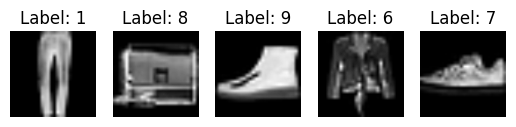

In [11]:
# 显示前 5 张图片
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.show()

## 3. 定义 ResNet 网络

In [12]:
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [13]:
# 输入和输出通道数相同的情况
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [14]:
# 增加输出通道数的同时减半输出的高和宽
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [15]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [16]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [17]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [18]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [19]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 3. 训练与评估

In [20]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)

    print('training on', device)
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = utils.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = utils.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], utils.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = utils.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.016, train acc 0.996, test acc 0.916
3425.6 examples/sec on cuda:0


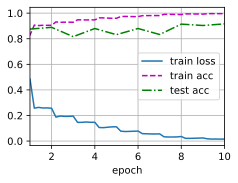

In [21]:
train(net, train_iter, test_iter, num_epochs=NUM_EPOCHS, lr=LR, device=utils.try_gpu())

In [22]:
def predict(model, dataloader, device):
    model.eval()  # 设置模型为评估模式
    predictions = []
    labels = []

    model.to(device)
    with torch.no_grad():  # 禁用梯度计算
        for data, label in dataloader:  # 假设 dataloader 返回的数据和标签
            data = data.to(device)  # 将数据移到 GPU（如果有的话）
            outputs = model(data)  # 获取模型输出
            _, predicted = torch.max(outputs, dim=1)  # 获取预测类别
            predictions.extend(predicted.cpu().tolist())  # 保存预测结果
            labels.extend(label.numpy())

    return labels, predictions

labels, predictions = predict(net, test_iter, utils.try_gpu())

topn = 5
print('\n'.join([f'y_true={i}, y_pred={j}' for i, j in zip(labels[:topn], predictions[:topn])]))

y_true=9, y_pred=9
y_true=2, y_pred=2
y_true=1, y_pred=1
y_true=1, y_pred=1
y_true=6, y_pred=0


In [23]:
y_true = [int(e) for e in labels]
y_label = [int(e) for e in predictions]

utils.eval_multi(y_true=y_true, y_label=y_label)

accuracy: 0.9161
precision: 0.9164
recall: 0.9161
f1_score: 0.9160
confusion matrix:
[[878   0  10   9   2   1  92   0   8   0]
 [  3 980   1  11   1   0   2   0   2   0]
 [ 26   2 895   6  34   0  37   0   0   0]
 [ 29   5  10 875  43   0  36   0   2   0]
 [  2   1  48  10 894   0  43   0   2   0]
 [  0   0   0   0   0 976   0  21   0   3]
 [ 94   1  68  17  70   0 742   0   8   0]
 [  0   0   0   0   0   6   0 966   0  28]
 [  4   1   0   1   1   1   5   3 984   0]
 [  0   0   0   0   0   6   1  22   0 971]]


参考：

- d2l: [resnet](http://zh-v2.d2l.ai/chapter_convolutional-modern/resnet.html)
- 数据集：[fashionmnist](https://www.kaggle.com/datasets/zalando-research/fashionmnist/code)